## Setup

In [1]:
from basicterm_me_heavylight_numpy import (
    model_point_table,
    premium_table,
    ModelPoints,
    assume,
    model,
    TermME,
)
import numpy as np
import pandas as pd
from heavylight import LightModel
from typing import Callable
from heavylight.memory_optimized_cache import FunctionCall


def calculate_cache_graph_size(model: LightModel):
    cg = model.cache_graph
    return sum(
        np.array(val).nbytes for cache in cg.caches.values() for val in cache.values()
    )


def run_and_check_cache_size(
    model: LightModel,
    proj_len: int,
    should_track_cache_size: Callable[[int], bool] = lambda t: False
):
    sizes = {}
    for t in range(proj_len + 1):
        max_cache_size = cache_size = 0
        for func in model._single_param_timestep_funcs:
            if (
                FunctionCall(func._func.__name__, (t,), frozenset())
                in model.cache_graph.all_calls
            ):
                continue
            func(t)
            if should_track_cache_size(t):
                cache_size = calculate_cache_graph_size(model)
                max_cache_size = max(max_cache_size, cache_size)
        if should_track_cache_size(t):
            sizes[t] = max_cache_size
    return sizes


def get_can_clear(model_miniature: TermME, optimization_proj_len, should_track_cache_size: Callable):
    optimization_cache_sizes = run_and_check_cache_size(
        model_miniature, optimization_proj_len, should_track_cache_size
    )
    model_miniature.OptimizeMemoryAndReset()
    return model_miniature.cache_graph.can_clear, optimization_cache_sizes

In [12]:
mp = ModelPoints(model_point_table, premium_table)
mp_big = ModelPoints(model_point_table, premium_table, size_multiplier=10)
mp_huge = ModelPoints(model_point_table, premium_table, size_multiplier=100)
mp_huger = ModelPoints(model_point_table, premium_table, size_multiplier=1000)
mp_monster = ModelPoints(model_point_table, premium_table, size_multiplier=10000)
mp_miniature = ModelPoints(model_point_table[:1], premium_table)
model = TermME(mp, assume)
model_miniature = TermME(mp_miniature, assume)
model_big = TermME(mp_big, assume)
model_huge = TermME(mp_huge, assume)
model_huger = TermME(mp_huger, assume)
model_monster = TermME(mp_monster, assume)
shared_should_log = lambda t: (t % 10 == 0)
can_clear, optimization_cache_sizes = get_can_clear(model_miniature, 277, shared_should_log) # slow because O(N^2) in timesteps, counting bytes

In [3]:
def reset_preserve_clearable(model: LightModel, can_clear):
    model.ResetCache()
    model.cache_graph.can_clear = can_clear

## Memory savings graph

In [16]:
model.ResetCache()
cache_sizes_uncleared = run_and_check_cache_size(model, 277, shared_should_log)

In [17]:
reset_preserve_clearable(model, can_clear)
cache_sizes_cleared = run_and_check_cache_size(model, 277, shared_should_log)

In [18]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'timestep': list(cache_sizes_uncleared.keys()),
    'cache_size_uncleared': list(cache_sizes_uncleared.values()),
    'cache_size_cleared': list(cache_sizes_cleared.values()),
    'optimization_cache_size': list(optimization_cache_sizes.values())
})
results_df["Memory Reduction"] = results_df["cache_size_uncleared"] / results_df["cache_size_cleared"]
results_df_truncated = results_df[:5]

Text(0, 0.5, 'cache size ratio, uncleared / cleared')

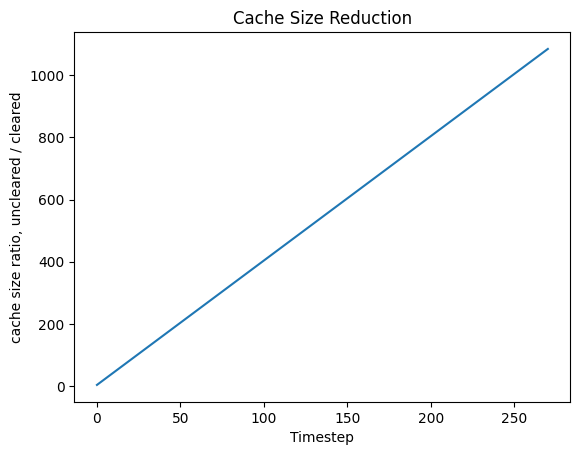

In [19]:
plt.plot(results_df.timestep, results_df["Memory Reduction"], label='Memory Reduction')
# title is cache size reduction
plt.title("Cache Size Reduction")
plt.xlabel("Timestep")
plt.ylabel("cache size ratio, uncleared / cleared")

In [20]:
model.mp = mp_big
model.OptimizeMemoryAndReset()
cache_sizes_optimized = run_and_check_cache_size(model, 5)

## working